In [4]:
# This is an implementation of the model found in this paper:
# https://arxiv.org/pdf/1611.01599.pdf

# 1: Initial Setup

In [ ]:
# install dependencies
# pip install command:                  !pip install opencv-python matplotlib imageio gdown tensorflow
# pip see installed packages command:   !pip list

# create virtual environment (Mac):     python3 -m venv [name]
# activate virtual environment (Mac):   source [name]/bin/activate
# deactivate virtual environment (Mac): deactivate

# add venv to jupyter kernels:          python -m ipykernel install --user --name=lipread --display-name "Python (lipread)"

In [2]:
# import modules
import os
import cv2
import gdown
import imageio
import numpy as np
from typing import List
import tensorflow as tf
from matplotlib import pyplot as plt

In [3]:
# prevent out of memory (OOM) errors by setting GPU memory consumption growth
physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.xperimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 2: Data Loading/Preprocessing

In [ ]:
if not os.path.exists('../data'):
    print("Data directory not found, downloading...")
    url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
    output = '../data.zip'
    gdown.download(url, output, quiet = False)
    gdown.extractall('../data.zip', output='../')
else:
    print("Data directory already exists, downloading skipped.")

Data directory already exists, downloading skipped.


In [5]:
# create array of every possible character expected to be encountered within annotations
vocab = [char for char in "abcdefghijklmnopqrstuvwxyz'?!0123456789 "]

# create a bidirectional mapping between characters and integers to enable easy conversion between character sequences and their corresponding numerical representations
char_to_num = tf.keras.layers.StringLookup(vocabulary = vocab, oov_token = "") # convert characters to numbers
num_to_char = tf.keras.layers.StringLookup(vocabulary = char_to_num.get_vocabulary(), oov_token = "", invert = True) # convert numbers to characters

# debugging
print(
    f"The vocabulary list: {char_to_num.get_vocabulary()} "
    f"(size = {char_to_num.vocabulary_size()})"
)

The vocabulary list: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size = 41)


In [6]:
# data loading function (takes in a data path and outputs a list of floats)
def load_video(path: str) -> List[float]:

    cap = cv2.VideoCapture(path) # create a video capture instance

    # loop through each frame and store in an array
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        _, frame = cap.read() # read in video frame data
        frame = tf.image.rgb_to_grayscale(frame) # convert from RGB to grayscale to reduce amount of data to be processed
        frames.append(frame[190:236, 80:220, :]) # static slicing for trimming down frame to isolate to mouth region
    cap.release()

    # standardization of frame data through Z-score normalization
    mean = tf.math.reduce_mean(frames) # calculate mean
    std = tf.math.reduce_std(tf.cast(frames, tf.float32)) # calculate standard deviation
    return tf.cast((frames - mean), tf.float32) / std # return standardized frame data

In [7]:
# function to load alignments (takes in a data path and outputs a list of strings)
def load_alignments(path: str) -> List[str]:

    # read in lines
    with open(path, 'r') as f:
        lines = f.readlines()

    # loop through each line
    tokens = []
    for line in lines:
        line = line.split() # split line into a list of elements by each space
        # append third element of line to an array (ignore any lines that contain 'sil')
        if line[2] != 'sil':
            tokens = [*tokens, line[2]]
            
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding = 'UTF-8'), (-1)))[1:] # return the numerical values of characters found in the line elements

In [8]:
# function to load data (takes in a data path and outputs frames and alignments)
def load_data(path: str):
    path = bytes.decode(path.numpy())

    file_name = path.split('/')[-1].split('.')[0] # file name splitting for Mac
    # file_name = path.split('\\')[-1].split('.')[0] # file name splitting for Windows

    video_path = os.path.join('../data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('../data', 'alignments', 's1', f'{file_name}.align')

    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments # return frames (75 frames x 46px height x 140px width x 1 color channel) and alignments (21 tokens)

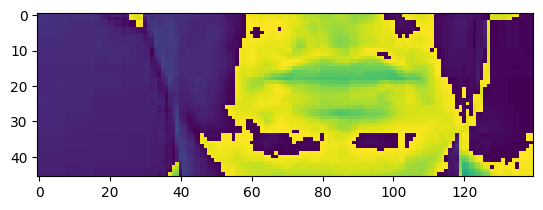

['i', 'n', 'b', 'l', 'u', 'e', 'a', 't', 'l', 's', 'i', 'x', 'n', 'o', 'w']


In [9]:
# debugging
test_path = '../data/s1/bbal6n.mpg'
test_frames, test_alignments = load_data(tf.convert_to_tensor(test_path))
[plt.imshow(test_frames[f_index]) and plt.show() for f_index in range(1)] # display first n frames as plots
print([bytes.decode(x) for x in num_to_char(test_alignments.numpy()).numpy()]) # display corresponding alignment as characters in an array

In [14]:
# mappable processing function (takes in a data path and outputs frames and alignments as a tuple of tensors)
def mappable_function(path: str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64)) # wrap load_data function as a TensorFlow operation
    return result

In [ ]:
data = tf.data.Dataset.list_files('../data/s1/*.mpg') # obtain all video files in given directory
data = data.shuffle(500, reshuffle_each_iteration = False) # shuffle an amount of data specified by the cache size
data = data.map(mappable_function) # transforms the dataset of file paths into a new dataset
data = data.padded_batch(2, padded_shapes = ([75, None, None, None], [40])) # create new TensorFlow dataset containing batches of 2 elements (the frames tensor within each batch is padded to have a fixed size of 75 frames)
data = data.prefetch(tf.data.AUTOTUNE) # fetch data from next iteration while current iteration is still being processed which mitigates bottlenecking (the argument 'tf.data.AUTOTUNE' is a special value that allows TensorFlow to automatically tune the prefetching buffer size based on available system resources)

In [16]:
# train/test data partitioning
train = data.take(450)
test = data.skip(450)

In [17]:
# debugging
sample_data = data.as_numpy_iterator().next(); sample_data[0] # obtain frames from data
# imageio.mimsave('./animation.gif', test_data[0][1], duration = 100) # create an animated GIF file from the sequence of frames
tf.strings.reduce_join([num_to_char(word) for word in sample_data[1][0]]) # display second alignment in batch as characters

<tf.Tensor: shape=(), dtype=string, numpy=b'etredatufourplease'>

# 4: Deep Neural Network Architecture

In [18]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [19]:
# neural network architecture
def create_model(vocab_size: int) -> Sequential:
    model = Sequential() # instantiation of model

    # first convolution (128 convolution kernels, 3x3x3 kernel size, frame data shape, padding is same to preserve input shape)
    model.add(Conv3D(128, 3, input_shape = (75, 46, 140, 1), padding = 'same'))
    model.add(Activation('relu')) # provide non-linearity outputs using ReLU function
    model.add(MaxPool3D((1, 2, 2))) # condense output down through max pooling

    # second convolution (256 convolution kernels, 3x3x3 kernel size, frame data shape, padding is same to preserve input shape)
    model.add(Conv3D(256, 3, padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1, 2, 2)))

    # third convolution (75 convolution kernels, 3x3x3 kernel size, frame data shape, padding is same to preserve input shape)
    model.add(Conv3D(75, 3, padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1, 2, 2)))

    model.add(TimeDistributed(Reshape((-1,)))) # independently apply flatten operation on every temporal slice of input

    # first bidirectional LSTM (128 LSTM hidden units, initialize weights with orthogonal matrices, return a sequence of outputs instead of a single final output)
    model.add(Bidirectional(LSTM(128, kernel_initializer = 'Orthogonal', return_sequences = True)))
    model.add(Dropout(0.5)) # drop out 50% of the units

    # second bidirectional LSTM
    model.add(Bidirectional(LSTM(128, kernel_initializer = 'Orthogonal', return_sequences = True)))
    model.add(Dropout(0.5))

    # fully connected dense layer (number of neurons in output layer equal to vocab size, weights of neurons initialized with he_normal initialization, activation function for output layer as softmax)
    model.add(Dense(vocab_size, kernel_initializer = 'he_normal', activation = 'softmax'))

    return model

# debugging
model = create_model(char_to_num.vocabulary_size())
model.summary()
y_hat = model.predict(sample_data[0])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

# 5: Model Training

In [20]:
# function for learning rate scheduling
def scheduler(epoch, lr):
    if epoch < 30:
        return lr # output learning rate if epochs is below certain threshold
    else:
        return lr * tf.math.exp(-0.1) # otherwise reduce the learning rate using exponential function

In [21]:
# function for calculating loss between a continuous (unsegmented) time series and a target sequence
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype = 'int64') # get the number of examples in the batch
    input_len = tf.cast(tf.shape(y_pred)[1], dtype = 'int64') # get the length of the predicted sequence
    label_len = tf.cast(tf.shape(y_true)[1], dtype = 'int64') # get the length of the true sequence

    # expand input_len and label_len to match the batch size
    input_len = input_len * tf.ones(shape = (batch_len, 1), dtype = 'int64')
    label_len = label_len * tf.ones(shape = (batch_len, 1), dtype = 'int64')

    # compute and return the CTC loss using tf.keras.backend.ctc_batch_cost
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_len, label_len)
    return loss

In [22]:
# custom callback class that generates and prints examples after each epoch during training
class ProduceExample(tf.keras.callbacks.Callback):

    # constructor that initializes callback with a dataset iterator
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    # function called at the end of each training epoch to generate and print examples
    def on_epoch_end(self, epoch, logs = None) -> None:
        data = self.dataset.next() # get the next batch of data from dataset
        y_hat = self.model.predict(data[0]) # predict sequences using model
        decoded = tf.keras.backend.ctc_decode(y_hat, [75, 75], greedy = False)[0][0].numpy() # decodes predicted sequences using CTC decoding

        # loop through each example in the batch and print original ground truth sequences along with predicted sequences
        # for x in range(len(y_hat)):
        #     print('Original: ', tf.string.reduce_join([vocab[word] + ' ' for word in data[1][x]])).numpy().decode('utf-8')
        #     print('Prediction: ', tf.string.reduce_join([vocab[word] + ' ' for word in decoded[x]])).numpy().decode('utf-8')
        #     print('~' * 100) # print separator line after each example

        # loop through each example in the batch and print original ground truth sequences along with predicted sequences
        for x in range(len(y_hat)):
            # convert original sequence to string format
            str_tensor_original = tf.constant([vocab[word] + ' ' for word in data[1][x]])
            str_original = tf.strings.reduce_join(str_tensor_original).numpy().decode('utf-8')
            print('Original: ', str_original)

            # convert predicted sequence to string format
            str_tensor_prediction = tf.constant([vocab[word] + ' ' for word in decoded[x]])
            str_prediction = tf.strings.reduce_join(str_tensor_prediction).numpy().decode('utf-8')
            print('Prediction: ', str_prediction)

            # separator line after each example
            print('~' * 100)

In [23]:
# # compile model
# model.compile(optimizer = Adam(learning_rate = 0.0001), loss = CTCLoss)

# # define callbacks
# checkpoint_callback = ModelCheckpoint('models/model.weights.h5', monitor = 'loss', save_weights_only = True) # responsible for saving the model's weights during training
# schedule_callback = LearningRateScheduler(scheduler) # allows for scheduling changes to the learning rate during training
# example_callback = ProduceExample(data) # responsible for generating and printing examples at the end of each epoch during training

# # train model on given dataset for specified number of epochs
# model.fit(train, validation_data = test, epochs = 100, callbacks = [checkpoint_callback, schedule_callback, example_callback])

# 5: Model Testing

In [24]:
# model.load_weights('models/checkpoint')
# model.save_weights('models/model.weights.h5')

In [26]:
# extract model checkpoints externally
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet = False)
# gdown.extractall('checkpoints.zip', 'models')

# load checkpoints locally
# model.load_weights('models/model.weights.h5')
model.load_weights('models/checkpoint')

In [27]:
# debugging
test_data = test.as_numpy_iterator().next()
y_hat = model.predict(test_data[0])
decoded = tf.keras.backend.ctc_decode(y_hat, input_length = [75, 75], greedy = True)[0][0].numpy()

# actual text
print('REAL TEXT', '~' * 100)
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in test_data[1]]

# predicted text
print('PREDICTIONS', '~' * 100)
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

[mpeg1video @ 0x30dd184c0] ac-tex damaged at 22 17
[mpeg1video @ 0x30dd184c0] Warning MVs not available


1/1 [==============================] - 2s 2s/step
REAL TEXT ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PREDICTIONS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin9green9by9b9oe9sooon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay9blue9by9e9three9again'>]

In [28]:
sample = load_data(tf.convert_to_tensor('./data/s1/swwi9s.mpg')) # load in new video data
y_hat = model.predict(tf.expand_dims(sample[0], axis = 0)) # perform prediction
decoded = tf.keras.backend.ctc_decode(y_hat, input_length = [75], greedy = True)[0][0].numpy() # decode prediction

# actual text
print('~' * 100)
actual_text = tf.strings.reduce_join([num_to_char(word) for word in sample[1]])
print('ACTUAL TEXT:', actual_text.numpy().decode('utf-8'))

# predicted text
print('~' * 100)
predicted_text = tf.strings.reduce_join([num_to_char(word) for word in decoded])
print('PREDICTED TEXT:', ' '.join(predicted_text.numpy().decode('utf-8').split('9')))

1/1 [==============================] - 1s 1s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ACTUAL TEXT: etwhitewithininesoon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PREDICTED TEXT: set white with i nine soon
